#Data Preparation

## Required Inputs

In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import random

In [2]:
#Mount Data From Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Read Data

In [3]:
#Mount Data From Drive
AC_df=pd.read_csv('gdrive/My Drive/Colab Notebooks/LAMP/00_df_raw_AC.csv')
MC_df=pd.read_csv('gdrive/My Drive/Colab Notebooks/LAMP/00_df_raw_MC.csv')

#Simple Machine Learning Algorithm

##Imports

In [4]:
#Importing Libraries
import numpy as np
import pandas as pd
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.externals import joblib
save_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/LAMP/output.csv')


## Read Data In

In [5]:
factor = pd.factorize(save_df['target'])
save_df['target'] = factor[0]
definitions = factor[1]
factor = pd.factorize(save_df['target'])
save_df['target'] = factor[0]
definitions = factor[1]
print(save_df.target.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64
Int64Index([0, 1, 2, 3, 4], dtype='int64')


### Finding  T_m (temperature at max F value) to use as feature for ML
#### Melt is in 43:107

In [6]:
melts = save_df.iloc[:,43:107]

In [7]:
max_values = melts.max(axis=1)
max_columns = melts.idxmax(axis=1)
result_df = pd.DataFrame({'Max Value': max_values, 'Max Column': max_columns})
print(result_df)
save_df = pd.concat([save_df, max_columns], axis=1)

       Max Value Max Column
0       0.200031         90
1       0.207160         90
2       0.194193         90
3       0.204077         90
4       0.208175         90
...          ...        ...
50451   0.207492       87.5
50452   0.211392       87.5
50453   0.211520       87.5
50454   0.209809       87.5
50455   0.207231       87.5

[50456 rows x 2 columns]


In [8]:
import random

def split_list_randomly(input_list, ratios):
    random.shuffle(input_list)
    split_indices = [0]
    cumulative_ratio = 0

    for ratio in ratios:
        cumulative_ratio += ratio
        split_index = int(len(input_list) * cumulative_ratio)
        split_indices.append(split_index)

    split_lists = [input_list[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
    return split_lists

In [9]:
df = save_df

unique_elements = df['group_ID'].unique().tolist()

train_ratio = 0.8
test_ratio = 0.2

split = split_list_randomly(unique_elements, [train_ratio,test_ratio])

train_df = df[df['group_ID'].isin(split[0])]
test_df = df[df['group_ID'].isin(split[1])]

unique_elements = train_df['group_ID'].unique().tolist()

split = split_list_randomly(unique_elements, [0.2,0.2,0.2,0.2,0.2])
df_sub0 = train_df[train_df['group_ID'].isin(split[0])]
df_sub1 = train_df[train_df['group_ID'].isin(split[1])]
df_sub2 = train_df[train_df['group_ID'].isin(split[2])]
df_sub3 = train_df[train_df['group_ID'].isin(split[3])]
df_sub4 = train_df[train_df['group_ID'].isin(split[4])]

## Simple ML Algorithms

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = rf_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = rf_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

rf_acc_ac = test_accuracy

Cross-validation scores: [0.9991187486230447, 0.9998821866163996, 0.9923570773463772, 0.9991282689912827, 0.9947757945145842]
Mean accuracy: 1.00
Confusion Matrix:
[[1344    0    0    0    0]
 [  21 2289    0    0    0]
 [   0    0 3183    0    0]
 [   0   27    0 1163    0]
 [   0    0    0    0 1161]]
Test Accuracy: 0.99


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

knn_classifier = KNeighborsClassifier()

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = knn_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = knn_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

knn_acc_ac = test_accuracy

Cross-validation scores: [0.998678122934567, 0.9997643732327992, 0.9961785386731886, 0.9983810709838107, 0.9949934697431432]
Mean accuracy: 1.00
Confusion Matrix:
[[1344    0    0    0    0]
 [   5 2305    0    0    0]
 [   0    0 3183    0    0]
 [   0   41    0 1149    0]
 [   0    0    0    0 1161]]
Test Accuracy: 0.99


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='l1', alpha = 1.e-04,  l1_ratio = 1., max_iter = 1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

sgd_acc_ac = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Cross-validation scores: [0.982264816038775, 0.9627709707822809, 0.937480892693366, 0.9392278953922789, 0.9069438397910318]
Mean accuracy: 0.95
Confusion Matrix:
[[1334   10    0    0    0]
 [ 171 2139    0    0    0]
 [   0    0 3183    0    0]
 [   1  647    0  542    0]
 [   0    0    0   26 1135]]
Test Accuracy: 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier =  RidgeClassifier(alpha = 1.e-04, max_iter = 200)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L2_acc_ac = test_accuracy

Cross-validation scores: [0.9929499889843578, 0.9967012252591895, 0.9648425557933353, 0.9795765877957658, 0.9717022202873313]
Mean accuracy: 0.98
Confusion Matrix:
[[1326    8    0   10    0]
 [  49 2258    0    3    0]
 [   0    0 3183    0    0]
 [   0  148    0 1042    0]
 [   0    0    0   42 1119]]
Test Accuracy: 0.97


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=1.e-04, l1_ratio=0.5, max_iter=1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L1_L2_acc_ac = test_accuracy

Cross-validation scores: [0.9929499889843578, 0.9967012252591895, 0.9648425557933353, 0.9795765877957658, 0.9717022202873313]
Mean accuracy: 0.98
Confusion Matrix:
[[1326    8    0   10    0]
 [  49 2258    0    3    0]
 [   0    0 3183    0    0]
 [   0  148    0 1042    0]
 [   0    0    0   42 1119]]
Test Accuracy: 0.97


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier =  SGDClassifier(loss = 'hinge', alpha = 0.1,  l1_ratio = 1, max_iter = 200, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SGD_acc_ac = test_accuracy

Cross-validation scores: [0.6148931482705442, 0.8746465598491989, 0.3460715377560379, 0.7768368617683686, 0.5913147583804963]
Mean accuracy: 0.64
Confusion Matrix:
[[1344    0    0    0    0]
 [1563  747    0    0    0]
 [   0    0 3183    0    0]
 [  53 1135    2    0    0]
 [   0    6  996    0  159]]
Test Accuracy: 0.59


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier =  HistGradientBoostingClassifier(
                                    learning_rate = 0.01,
                                    min_samples_leaf =8,
                                    max_leaf_nodes = 4)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

GBT_acc_ac = test_accuracy

Cross-validation scores: [0.9968054637585371, 0.9943449575871819, 0.986242739223479, 0.9922789539227895, 0.9640835872877667]
Mean accuracy: 0.99
Confusion Matrix:
[[1333   11    0    0    0]
 [  73 2236    0    1    0]
 [   0    0 3183    0    0]
 [   3  237    0  949    1]
 [   4    0    0    0 1157]]
Test Accuracy: 0.96


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:107].values
y_test = test_df.iloc[:,2].values

classifier =  SVC(C = 1.e-07, kernel = 'linear', max_iter = 200, probability = True)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SVM_acc_ac = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-

Cross-validation scores: [0.8219872218550341, 0.9972902921771913, 0.8852033017425863, 0.7737235367372354, 0.9208750544188071]
Mean accuracy: 0.88
Confusion Matrix:
[[1002  342    0    0    0]
 [  18 2062    0  230    0]
 [   0    0 3183    0    0]
 [   0  122    0 1068    0]
 [   0    0    0   15 1146]]
Test Accuracy: 0.92


##MC + temperature at max F value

Cross-validation scores: [0.9991187486230447, 0.9995287464655985, 0.9963313971262611, 0.999252801992528, 0.9952111449717023]
Mean accuracy: 1.00
Confusion Matrix:
[[1344    0    0    0    0]
 [  14 2296    0    0    0]
 [   0    0 3183    0    0]
 [   0   30    0 1160    0]
 [   0    0    0    0 1161]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1344
           1       0.99      0.99      0.99      2310
           2       1.00      1.00      1.00      3183
           3       1.00      0.97      0.99      1190
           4       1.00      1.00      1.00      1161

    accuracy                           1.00      9188
   macro avg       1.00      0.99      0.99      9188
weighted avg       1.00      1.00      1.00      9188



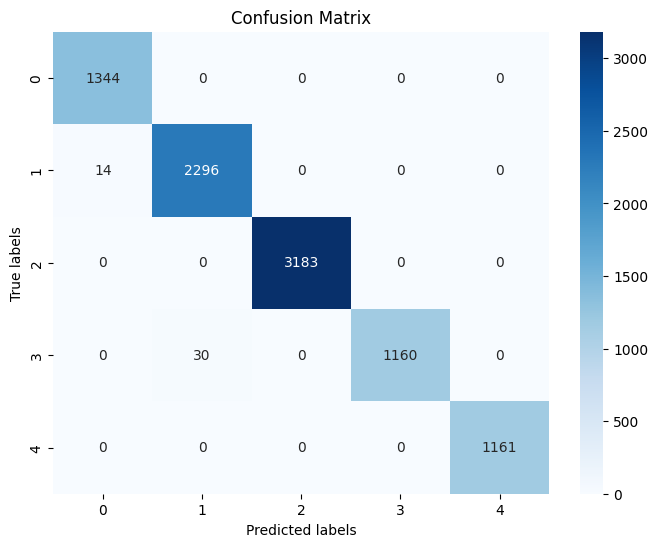

Test Accuracy: 1.00


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = rf_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = rf_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

print("Test Accuracy: %.2f" % test_accuracy)

rf_acc_all = test_accuracy


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

knn_classifier = KNeighborsClassifier()

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = knn_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = knn_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

knn_acc_all = test_accuracy

Cross-validation scores: [0.9985679665124477, 0.9994109330819981, 0.9958728217670437, 0.9982565379825654, 0.9946669569003047]
Mean accuracy: 1.00
Confusion Matrix:
[[1344    0    0    0    0]
 [   5 2305    0    0    0]
 [   0    0 3183    0    0]
 [   0   44    0 1146    0]
 [   0    0    0    0 1161]]
Test Accuracy: 0.99


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='l1', alpha = 1.e-04,  l1_ratio = 1., max_iter = 1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

sgd_acc_all = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Cross-validation scores: [0.9852390394359991, 0.885956644674835, 0.40706206053194743, 0.8078455790784558, 0.8333696125380932]
Mean accuracy: 0.78
Confusion Matrix:
[[1343    1    0    0    0]
 [ 332 1978    0    0    0]
 [   0    0 3183    0    0]
 [   1 1186    0    0    3]
 [   0    8    0    0 1153]]
Test Accuracy: 0.83


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier =  RidgeClassifier(alpha = 1.e-04, max_iter = 200)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L2_acc_all = test_accuracy

Cross-validation scores: [0.9929499889843578, 0.9967012252591895, 0.9625496789972485, 0.9805728518057285, 0.9723552459730083]
Mean accuracy: 0.98
Confusion Matrix:
[[1327    7    0   10    0]
 [  49 2257    0    4    0]
 [   0    0 3183    0    0]
 [   0  146    0 1044    0]
 [   0    0    0   38 1123]]
Test Accuracy: 0.97


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=1.e-04, l1_ratio=0.5, max_iter=1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L1_L2_acc_all = test_accuracy

Cross-validation scores: [0.9929499889843578, 0.9967012252591895, 0.9625496789972485, 0.9805728518057285, 0.9723552459730083]
Mean accuracy: 0.98
Confusion Matrix:
[[1327    7    0   10    0]
 [  49 2257    0    4    0]
 [   0    0 3183    0    0]
 [   0  146    0 1044    0]
 [   0    0    0   38 1123]]
Test Accuracy: 0.97


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier =  SGDClassifier(loss = 'hinge', alpha = 0.1,  l1_ratio = 1, max_iter = 200, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SGD_acc_all = test_accuracy

Cross-validation scores: [0.7822207534699273, 0.4533459000942507, 0.6571384897584837, 0.5285180572851805, 0.6429037875489769]
Mean accuracy: 0.61
Confusion Matrix:
[[ 415  929    0    0    0]
 [   1 2309    0    0    0]
 [   0    0 3183    0    0]
 [   0 1190    0    0    0]
 [   0 1149   12    0    0]]
Test Accuracy: 0.64


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier =  HistGradientBoostingClassifier(
                                    learning_rate = 0.01,
                                    min_samples_leaf =8,
                                    max_leaf_nodes = 4)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

GBT_acc_all = test_accuracy

Cross-validation scores: [0.9968054637585371, 0.9943449575871819, 0.9885356160195659, 0.990535491905355, 0.9646277753591641]
Mean accuracy: 0.99
Confusion Matrix:
[[1335    9    0    0    0]
 [  75 2234    0    1    0]
 [   0    0 3183    0    0]
 [   1  233    0  954    2]
 [   4    0    0    0 1157]]
Test Accuracy: 0.96


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,43:108].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,43:108].values
y_test = test_df.iloc[:,2].values

classifier =  SVC(C = 1.e-07, kernel = 'linear', max_iter = 200, probability = True)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SVM_acc_all = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-

Cross-validation scores: [0.880039656311963, 0.9987040527803959, 0.88168755732192, 0.7104607721046077, 0.9874836743578581]
Mean accuracy: 0.89
Confusion Matrix:
[[1331   13    0    0    0]
 [   2 2308    0    0    0]
 [   0    0 3183    0    0]
 [   0   90    0 1099    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.99


1 var


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = rf_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = rf_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

rf_acc = test_accuracy

Cross-validation scores: [0.9797312183300286, 0.9785579641847314, 0.9139406909202079, 0.9833125778331258, 0.914235959947758]
Mean accuracy: 0.95
Confusion Matrix:
[[1339    5    0    0    0]
 [ 196 2114    0    0    0]
 [   0    0 3183    0    0]
 [   1  576    0  612    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.91


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

knn_classifier = KNeighborsClassifier()

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    # X_train, y_train = X[train_indices], y[train_indices]
    # X_val, y_val = X[val_indices], y[val_indices]

    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = knn_classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = knn_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

knn_acc = test_accuracy

Cross-validation scores: [0.6730557391495924, 0.8899622997172478, 0.5985937022317334, 0.7950186799501868, 0.7665433173704832]
Mean accuracy: 0.74
Confusion Matrix:
[[1344    0    0    0    0]
 [1558  752    0    0    0]
 [   0    0 3183    0    0]
 [  22  555    0  612    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.77


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='l1', alpha = 1.e-04,  l1_ratio = 1., max_iter = 1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

sgd_acc = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Cross-validation scores: [0.6028860982595285, 0.4533459000942507, 0.26872516050137574, 0.4821917808219178, 0.7451023073574228]
Mean accuracy: 0.51
Confusion Matrix:
[[1344    0    0    0    0]
 [1558    0    0  752    0]
 [   0    0 3183    0    0]
 [  22    0    0 1167    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.75


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier =  RidgeClassifier(alpha = 1.e-04, max_iter = 200)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L2_acc = test_accuracy

Cross-validation scores: [0.573694646397885, 0.4533459000942507, 0.23570773463772546, 0.624159402241594, 0.49270787984327385]
Mean accuracy: 0.48
Confusion Matrix:
[[1344    0    0    0    0]
 [2310    0    0    0    0]
 [   0    0 3183    0    0]
 [1189    0    1    0    0]
 [   9    0 1152    0    0]]
Test Accuracy: 0.49


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=1.e-04, l1_ratio=0.5, max_iter=1000, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

LR_L1_L2_acc = test_accuracy

Cross-validation scores: [0.573694646397885, 0.4533459000942507, 0.23570773463772546, 0.624159402241594, 0.49270787984327385]
Mean accuracy: 0.48
Confusion Matrix:
[[1344    0    0    0    0]
 [2310    0    0    0    0]
 [   0    0 3183    0    0]
 [1189    0    1    0    0]
 [   9    0 1152    0    0]]
Test Accuracy: 0.49


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier =  SGDClassifier(loss = 'hinge', alpha = 0.1,  l1_ratio = 1, max_iter = 200, n_jobs=-1)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SGD_acc = test_accuracy

Cross-validation scores: [0.26657854152897115, 0.4533459000942507, 0.1183124426780801, 0.5042341220423412, 0.14627775359164127]
Mean accuracy: 0.30
Confusion Matrix:
[[1344    0    0    0    0]
 [2310    0    0    0    0]
 [   0 3183    0    0    0]
 [1190    0    0    0    0]
 [1161    0    0    0    0]]
Test Accuracy: 0.15


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier =  HistGradientBoostingClassifier(
                                    learning_rate = 0.01,
                                    min_samples_leaf =8,
                                    max_leaf_nodes = 4)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

GBT_acc = test_accuracy

Cross-validation scores: [0.9797312183300286, 0.9785579641847314, 0.9139406909202079, 0.9833125778331258, 0.914235959947758]
Mean accuracy: 0.95
Confusion Matrix:
[[1339    5    0    0    0]
 [ 196 2114    0    0    0]
 [   0    0 3183    0    0]
 [   1  576    0  612    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.91


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a sample dataset (replace with your own data)
X = save_df.iloc[:,107].values
y = save_df.iloc[:,2].values

X_test = test_df.iloc[:,107].values
y_test = test_df.iloc[:,2].values

classifier =  SVC(C = 1.e-07, kernel = 'linear', max_iter = 200, probability = True)

folds = [
    (pd.concat([df_sub4, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub0["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub4, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub1["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub4, df_sub3], axis=0)['Unnamed: 0'], df_sub2["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub4], axis=0)['Unnamed: 0'], df_sub3["Unnamed: 0"]),
    (pd.concat([df_sub0, df_sub1, df_sub2, df_sub3], axis=0)['Unnamed: 0'], df_sub4["Unnamed: 0"])
]

# Perform cross-validation
scores = []
for train_indices, val_indices in folds:
    # Get the training and testing data for the current fold
    X_train, y_train = X[train_indices].reshape(-1, 1), y[train_indices]
    X_test, y_test = X[test_indices].reshape(-1, 1), y[test_indices]

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = classifier.predict(X_val)

    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy score
    scores.append(accuracy)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy: %.2f" % (sum(scores) / len(scores)))

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

print("Test Accuracy: %.2f" % test_accuracy)

SVM_acc = test_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-

Cross-validation scores: [0.9797312183300286, 0.9785579641847314, 0.9139406909202079, 0.7056039850560398, 0.914235959947758]
Mean accuracy: 0.90
Confusion Matrix:
[[1339    5    0    0    0]
 [ 196 2114    0    0    0]
 [   0    0 3183    0    0]
 [   1  576    0  612    1]
 [   0    0    0    9 1152]]
Test Accuracy: 0.91


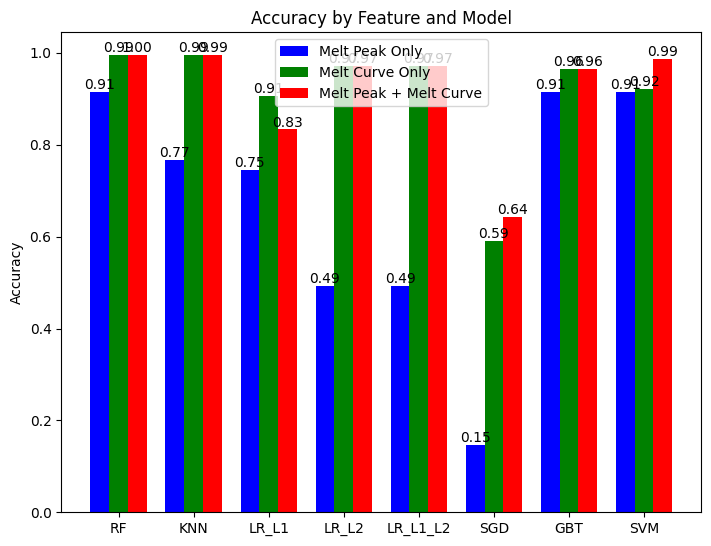

In [36]:
import matplotlib.pyplot as plt
import numpy as np

data = [
    [rf_acc, knn_acc, sgd_acc, LR_L2_acc, LR_L1_L2_acc, SGD_acc, GBT_acc, SVM_acc],
    [rf_acc_ac, knn_acc_ac, sgd_acc_ac, LR_L2_acc_ac, LR_L1_L2_acc_ac, SGD_acc_ac, GBT_acc_ac, SVM_acc_ac],
    [rf_acc_all, knn_acc_all, sgd_acc_all, LR_L2_acc_all, LR_L1_L2_acc_all, SGD_acc_all, GBT_acc_all, SVM_acc_all]
]

ind = np.arange(8)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bar_width = 0.25

bar1 = ax.bar(ind, data[0], color='b', width=bar_width)
bar2 = ax.bar(ind + bar_width, data[1], color='g', width=bar_width)
bar3 = ax.bar(ind + 2 * bar_width, data[2], color='r', width=bar_width)

ax.set_xlabel('Machine Learning Algorithms')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Feature and Model')

ax.set_xticks(ind + bar_width)
ax.set_xticklabels(('RF', 'KNN', 'LR_L1', 'LR_L2', 'LR_L1_L2', 'SGD', 'GBT', 'SVM'))

ax.legend((bar1[0], bar2[0], bar3[0]), ('Melt Peak Only', 'Melt Curve Only', 'Melt Peak + Melt Curve'))

# Add numbers on each bar
for bar_group in [bar1, bar2, bar3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                '%.2f' % height, ha='center', va='bottom')

plt.show()
